In [17]:
import random
import re
from datetime import date
from pathlib import Path
from typing import Union

import SimpleITK as sitk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import itertools
import os
from os.path import join
import sys
sys.path.append('/media/medical/gasperp/projects')
from monai_3D_U_net.src import project_config
sys.path.append(project_config.projects_dir_path)
from utilities import utilities, visualization_functions
from monai_3D_U_net.src.nnUnet import nnunet_config
from monai_3D_U_net.src.nnUnet.plotting_jupyters import plot_functions, special_cases

In [169]:
def read_csv(dataset_name):
    df = pd.read_csv(
    os.path.join(
        f"/media/medical/projects/head_and_neck/nnUnet/{dataset}/results/", 
        f"results.csv",
    )
    )
    df.loc[df['parameters'].isna(), 'parameters'] = '/'
    return df
def drop_recurring_columns(df):
    df = df.copy()
    
    names_to_be_dropped = {}
    names_to_stay = {}
    for col_name in df.columns.names:
        col_vals = df.columns.get_level_values(col_name).unique().values.tolist()
        if len(col_vals) == 1:
            names_to_be_dropped[col_name] = col_vals[0]
        else:
            names_to_stay[col_name] = col_vals
    df.columns = df.columns.droplevel(list(names_to_be_dropped.keys()))
    return df, names_to_be_dropped, names_to_stay

def plot_boxplots(df: pd.DataFrame, selection: Union[dict, list], xlabel_col_name='organ_name', exclude_missing_gt=True):
    if isinstance(selection, list):
        assert all([isinstance(i, dict) for i in selection]), "'selection' must either be dict or list of dicts"
        num_plots = len(selection)
    else:
        num_plots = 1
        selection = [selection]
        
    if num_plots == 1:
        ncols=1
        nrows=1
    else:
        ncols=2
        nrows = np.ceil(num_plots/ncols).astype(int)
        
    df, dropped_cols, _ = drop_recurring_columns(df)
    suptitle = ', '.join([f'{k}: {v}' for k, v in dropped_cols.items()])
    # if suptitle is very long: cut it in 100 characters pieces (each in new line)
    split_length = 100
    suptitle = '-\n'.join([suptitle[i:i+split_length] for i in range(0, len(suptitle), split_length)])
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 6*nrows+2), sharex=False, squeeze=False)
    fig.subplots_adjust(top=0.95)
    xlabels = df.columns.get_level_values(xlabel_col_name).unique().values.tolist()
    for _dict, ax in zip(selection, axes.flatten(order='F')):
        
        _df = df.xs(list(_dict.values()), level=list(_dict.keys()), axis=1)
        if exclude_missing_gt:
            _df = exclude_missing_gt_cases_from_df(_df)
        _df, _dropped, _ = drop_recurring_columns(_df)
        _df.boxplot(ax=ax, **dict(patch_artist=True))
        
        settings_dict = {**_dict, **_dropped}
        title = r', '.join([fr'{k}: $\bf{{{replace_underscore(v)}}}$' for k, v in settings_dict.items()])
        
        if ax.is_last_row():
            #ax.set_xticks(xlabels) 
            ax.set_xticklabels(xlabels)
            #ax.set_xticks(ax.get_xticks(), xlabels)    
            ax.tick_params(axis='x', labelrotation = 90)
        else:
            ax.set_xticklabels(['']*len(ax.get_xticks()))
        ax.set_title(title)
        # if metric is dice
        if 'dice' in str(_dict.get('metric')):
            ax.set_yticks(np.arange(0, 1.1, 0.1)) #, fontsize=12)
            
    fig.suptitle(suptitle, y=0.98)
    
def compute_mean_std_table(df_pivot, exclude_missing_gt=True):
    df_pivot = exclude_missing_gt_cases_from_df(df_pivot)
    df_pivot_cleaned, _, _ = drop_recurring_columns(df_pivot)
    df_t = df_pivot_cleaned.transpose()
    # df_t
    # df_t.xs('Arytenoids', level='organ_name')
    new_col_name = 'mean +/-, std; N=num'
    df_t[new_col_name] = df_t.mean(axis=1).round(3).astype(str) + ' +/- ' + df_t.std(axis=1).round(3).astype(str) + '; N=' + df_t.notna().sum(axis=1).astype(str)
    df_t = df_t.drop(df_t.columns[:-2], axis=1).reset_index()
    df_t = df_t.pivot(index='organ_name', columns=['metric', 'phase'], values=new_col_name)
    return df_t.sort_index(axis=1)

split_text = lambda text, split_length = 100: '-\n'.join([text[i:i+split_length] for i in range(0, len(text), split_length)])
exclude_missing_gt_cases_from_df = lambda df: df.xs(0, level='missing_organ_on_gt')
pivot_nnunet_results_df = lambda in_df: pd.pivot_table(in_df, values='value', index=['fname', 'missing_organ_on_gt', 'missing_organ_on_pred'], columns=['model_task_name', 'trainer_class', 'plans_name', 'checkpoint', 'prediction_mode', 'fold', 'phase', 'metric', 'parameters', 'organ_name'])
replace_underscore = lambda s, r='\,': s.replace('_', r)

# ISBI plots

## LOAD 150
ISBI baseline model second attempt, all organs, CT and MRI T1 modalities, fixed image intensities anomalies in batch1, coregistered all images to common frame, all organs or nothing

Index(['Unnamed: 0', 'organ_name', 'organ_label', 'metric', 'value',
       'parameters', 'model_task_number', 'model_task_name', 'fold',
       'trainer_class', 'plans_name', 'checkpoint', 'prediction_mode', 'phase',
       'fname'],
      dtype='object')
(33, 310)
[{'phase': 'test', 'metric': 'assd'}, {'phase': 'test', 'metric': 'average_surface_distance'}, {'phase': 'test', 'metric': 'hausdorff'}, {'phase': 'test', 'metric': 'surface_dice_at_tolerance'}, {'phase': 'test', 'metric': 'volumetric_dice'}, {'phase': 'train', 'metric': 'assd'}, {'phase': 'train', 'metric': 'average_surface_distance'}, {'phase': 'train', 'metric': 'hausdorff'}, {'phase': 'train', 'metric': 'surface_dice_at_tolerance'}, {'phase': 'train', 'metric': 'volumetric_dice'}] 10
5 2


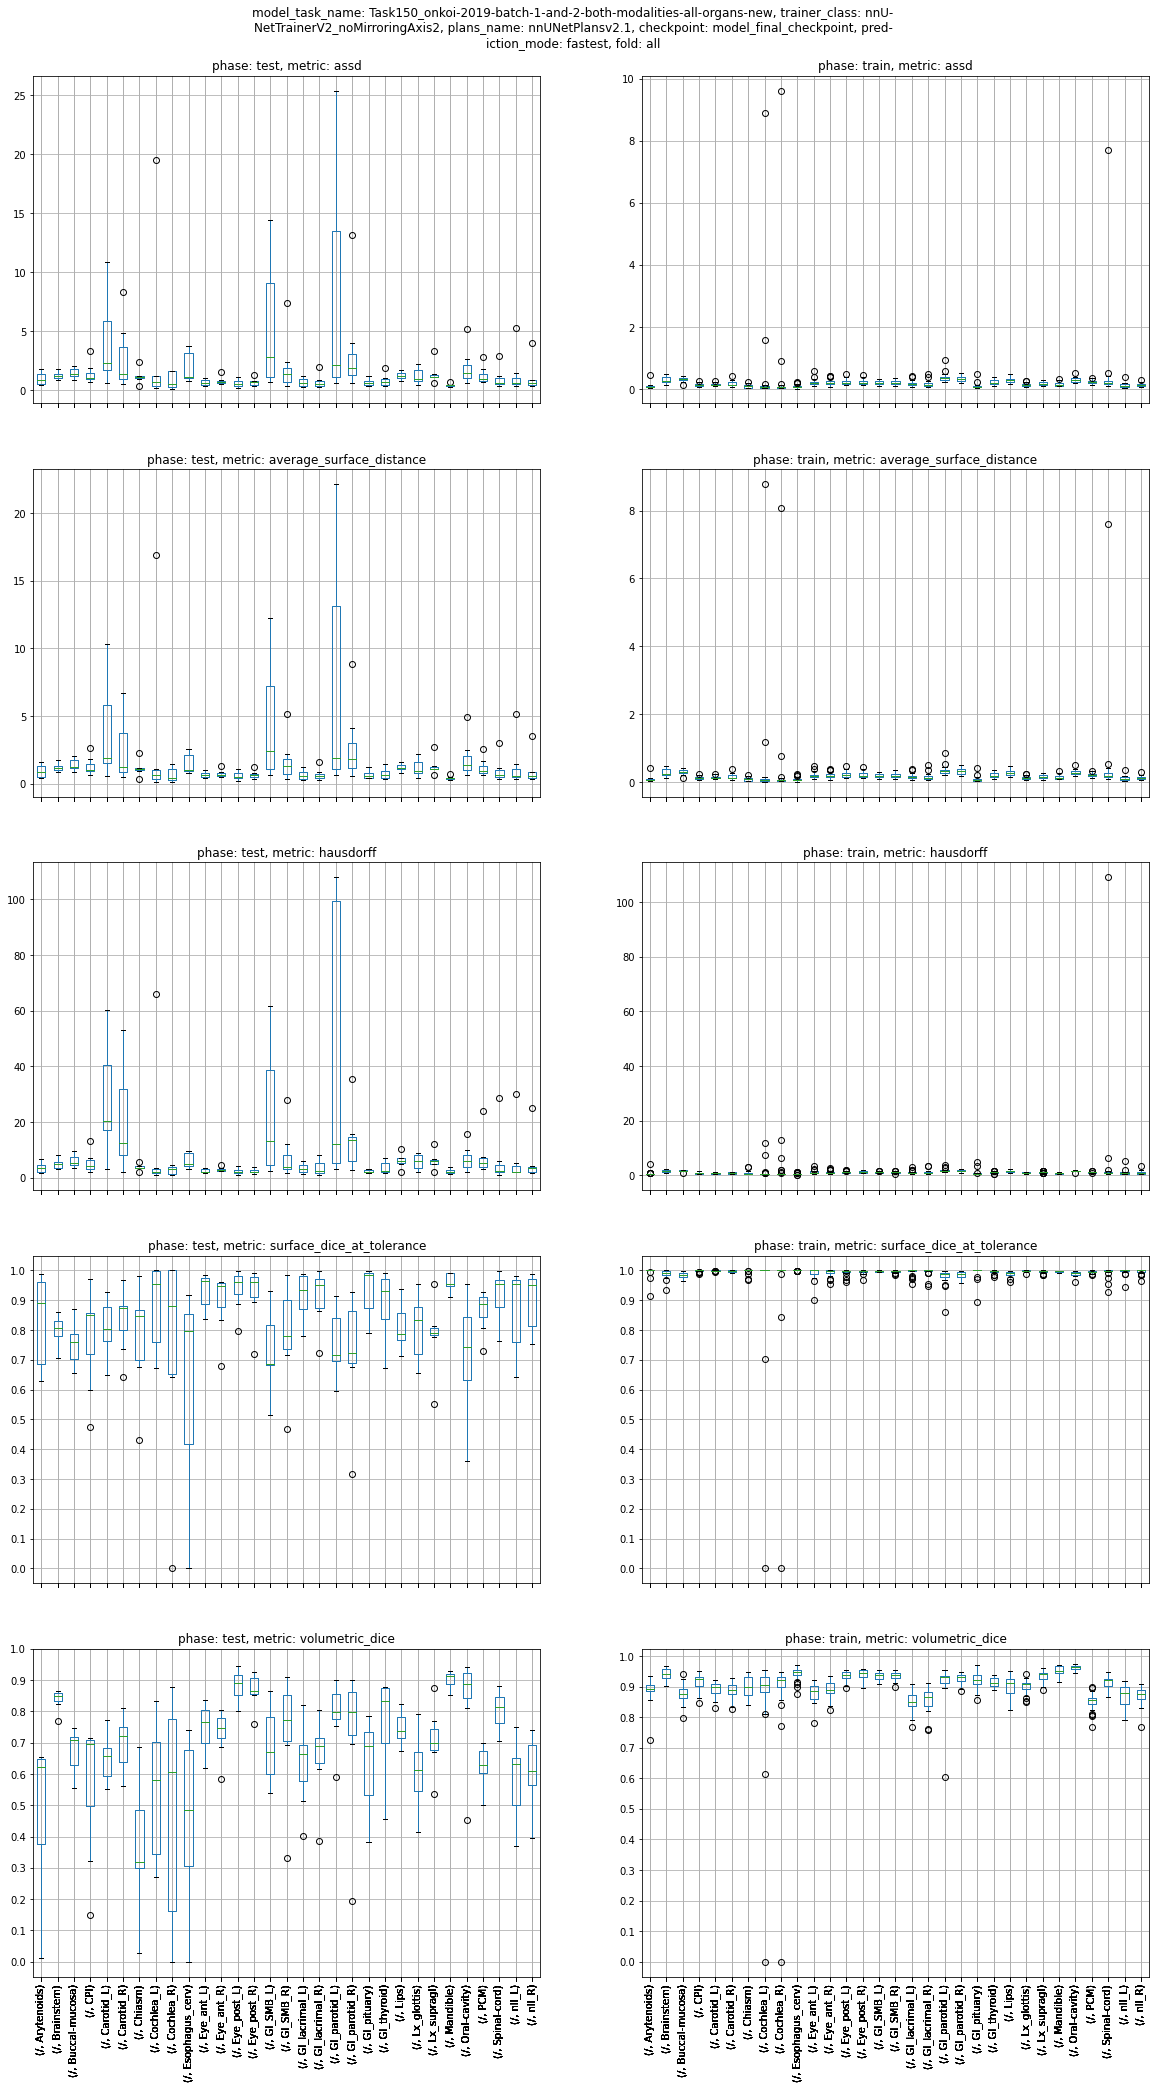

In [3]:
dataset = "Task150_onkoi-2019-batch-1-and-2-both-modalities-all-organs-new"
# stat_test = 'Mann-Whitney'
df = read_csv(dataset)
print(df.columns)
# df
df_pivot = pivot_nnunet_results_df(df)
print(df_pivot.shape)
df_pivot

df_pivot.columns.names
_, _, names_to_stay = drop_recurring_columns(df_pivot)

plot_parameters = ('phase', 'metric')
_tmp = {k: vals for k, vals in names_to_stay.items() if k in plot_parameters}
combinations = [dict(zip(list(_tmp.keys()), combination)) for combination in itertools.product(*list(_tmp.values()))]
combinations
print(combinations, len(combinations))
plot_boxplots(df_pivot, combinations)

## LOAD 154
ISBI baseline model, all organs, CT and MRI T1 modalities, coregistered all images to common frame, cropped in cor and sag to eliminate background and in ax to reduce size

Index(['Unnamed: 0', 'organ_name', 'organ_label', 'metric', 'value',
       'parameters', 'model_task_number', 'model_task_name', 'fold',
       'trainer_class', 'plans_name', 'checkpoint', 'prediction_mode', 'phase',
       'fname'],
      dtype='object')
(56, 258)
{'model_task_name': 'Task154_onkoi-2019-batch-1-and-2-both-modalities-all-cropped-cor-sag-ax', 'trainer_class': 'nnUNetTrainerV2_noMirroringAxis2', 'plans_name': 'nnUNetPlansv2.1', 'checkpoint': 'model_final_checkpoint', 'prediction_mode': 'normal', 'fold': 'all'}
{'phase': ['test', 'train'], 'metric': ['assd', 'average_surface_distance', 'hausdorff', 'surface_dice_at_tolerance', 'volumetric_dice'], 'parameters': ['no_parameters', 'function=mean', 'percentile=95', 'tolerance_mm=2.0'], 'organ_name': ['Brainstem', 'Buccal-mucosa', 'Carotid_L', 'Carotid_R', 'Chiasm', 'Cochlea_L', 'Cochlea_R', 'Eye_ant_L', 'Eye_ant_R', 'Eye_post_L', 'Eye_post_R', 'Gl_lacrimal_L', 'Gl_lacrimal_R', 'Gl_parotid_L', 'Gl_parotid_R', 'Gl_pituary', 'L

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1183: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1128: RuntimeWarning: invalid value encountered in double_scalars
  notch_min = med - 1.57 * iqr / np.sqrt(N)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1183: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1128: RuntimeWarning: invalid value encountered in double_scalars
  notch_min = med - 1.57 * iqr / np.sqrt(N)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:61: Matplotli

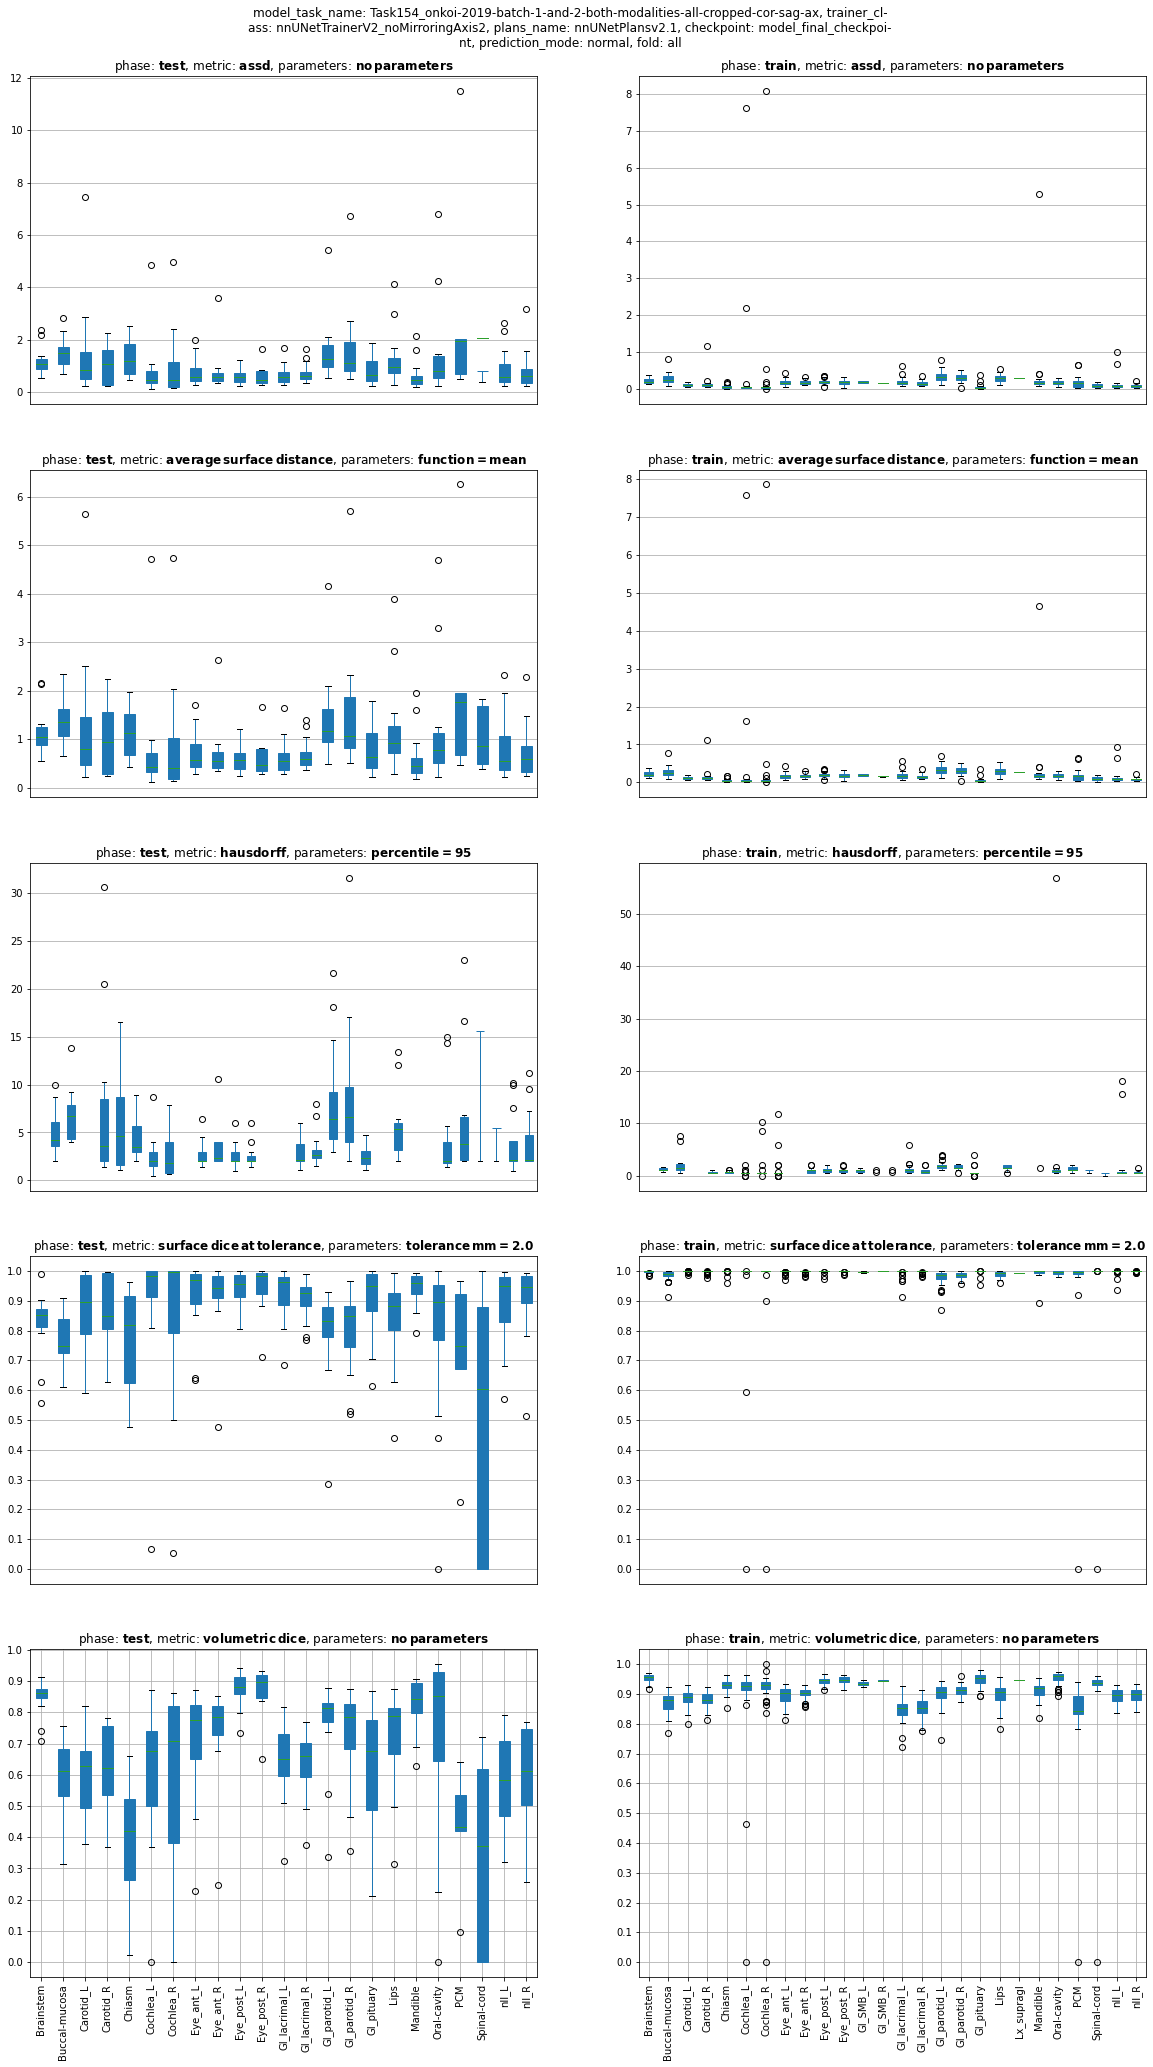

In [71]:
dataset = "Task154_onkoi-2019-batch-1-and-2-both-modalities-all-cropped-cor-sag-ax"
# stat_test = 'Mann-Whitney'
df = read_csv(dataset)
print(df.columns)
# df
df_pivot = pivot_nnunet_results_df(df)
print(df_pivot.shape)
# df_pivot

df_pivot.columns.names
_, dropped_names, names_to_stay = drop_recurring_columns(df_pivot)
print(dropped_names)
print(names_to_stay)

plot_parameters = ('phase', 'metric')
_tmp = {k: vals for k, vals in names_to_stay.items() if k in plot_parameters}
combinations = [dict(zip(list(_tmp.keys()), combination)) for combination in itertools.product(*list(_tmp.values()))]
combinations
print(combinations, len(combinations))
plot_boxplots(df_pivot, combinations)

## LOAD 155
ISBI baseline model, all organs, CT and MRI T1 modalities, coregistered all images to common frame, cropped in cor and sag to eliminate background

Index(['Unnamed: 0', 'organ_name', 'organ_label', 'metric', 'value',
       'parameters', 'model_task_number', 'model_task_name', 'fold',
       'trainer_class', 'plans_name', 'checkpoint', 'prediction_mode', 'phase',
       'fname'],
      dtype='object')
(56, 258)
{'model_task_name': 'Task155_onkoi-2019-batch-1-and-2-both-modalities-all-cropped-cor-sag', 'trainer_class': 'nnUNetTrainerV2_noMirroringAxis2', 'plans_name': 'nnUNetPlansv2.1', 'checkpoint': 'model_final_checkpoint', 'prediction_mode': 'normal', 'fold': 'all'}
{'phase': ['test', 'train'], 'metric': ['assd', 'average_surface_distance', 'hausdorff', 'surface_dice_at_tolerance', 'volumetric_dice'], 'parameters': ['/', 'function=mean', 'percentile=95', 'tolerance_mm=2.0'], 'organ_name': ['Brainstem', 'Buccal-mucosa', 'Carotid_L', 'Carotid_R', 'Chiasm', 'Cochlea_L', 'Cochlea_R', 'Eye_ant_L', 'Eye_ant_R', 'Eye_post_L', 'Eye_post_R', 'Gl_lacrimal_L', 'Gl_lacrimal_R', 'Gl_parotid_L', 'Gl_parotid_R', 'Gl_pituary', 'Lips', 'Mandible

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1128: RuntimeWarning: invalid value encountered in double_scalars
  notch_min = med - 1.57 * iqr / np.sqrt(N)
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1183: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1128: RuntimeWarning: invalid value encountered in double_scalars
  notch_min = med - 1.57 * iqr / np.sqrt(N)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1183: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1128: 

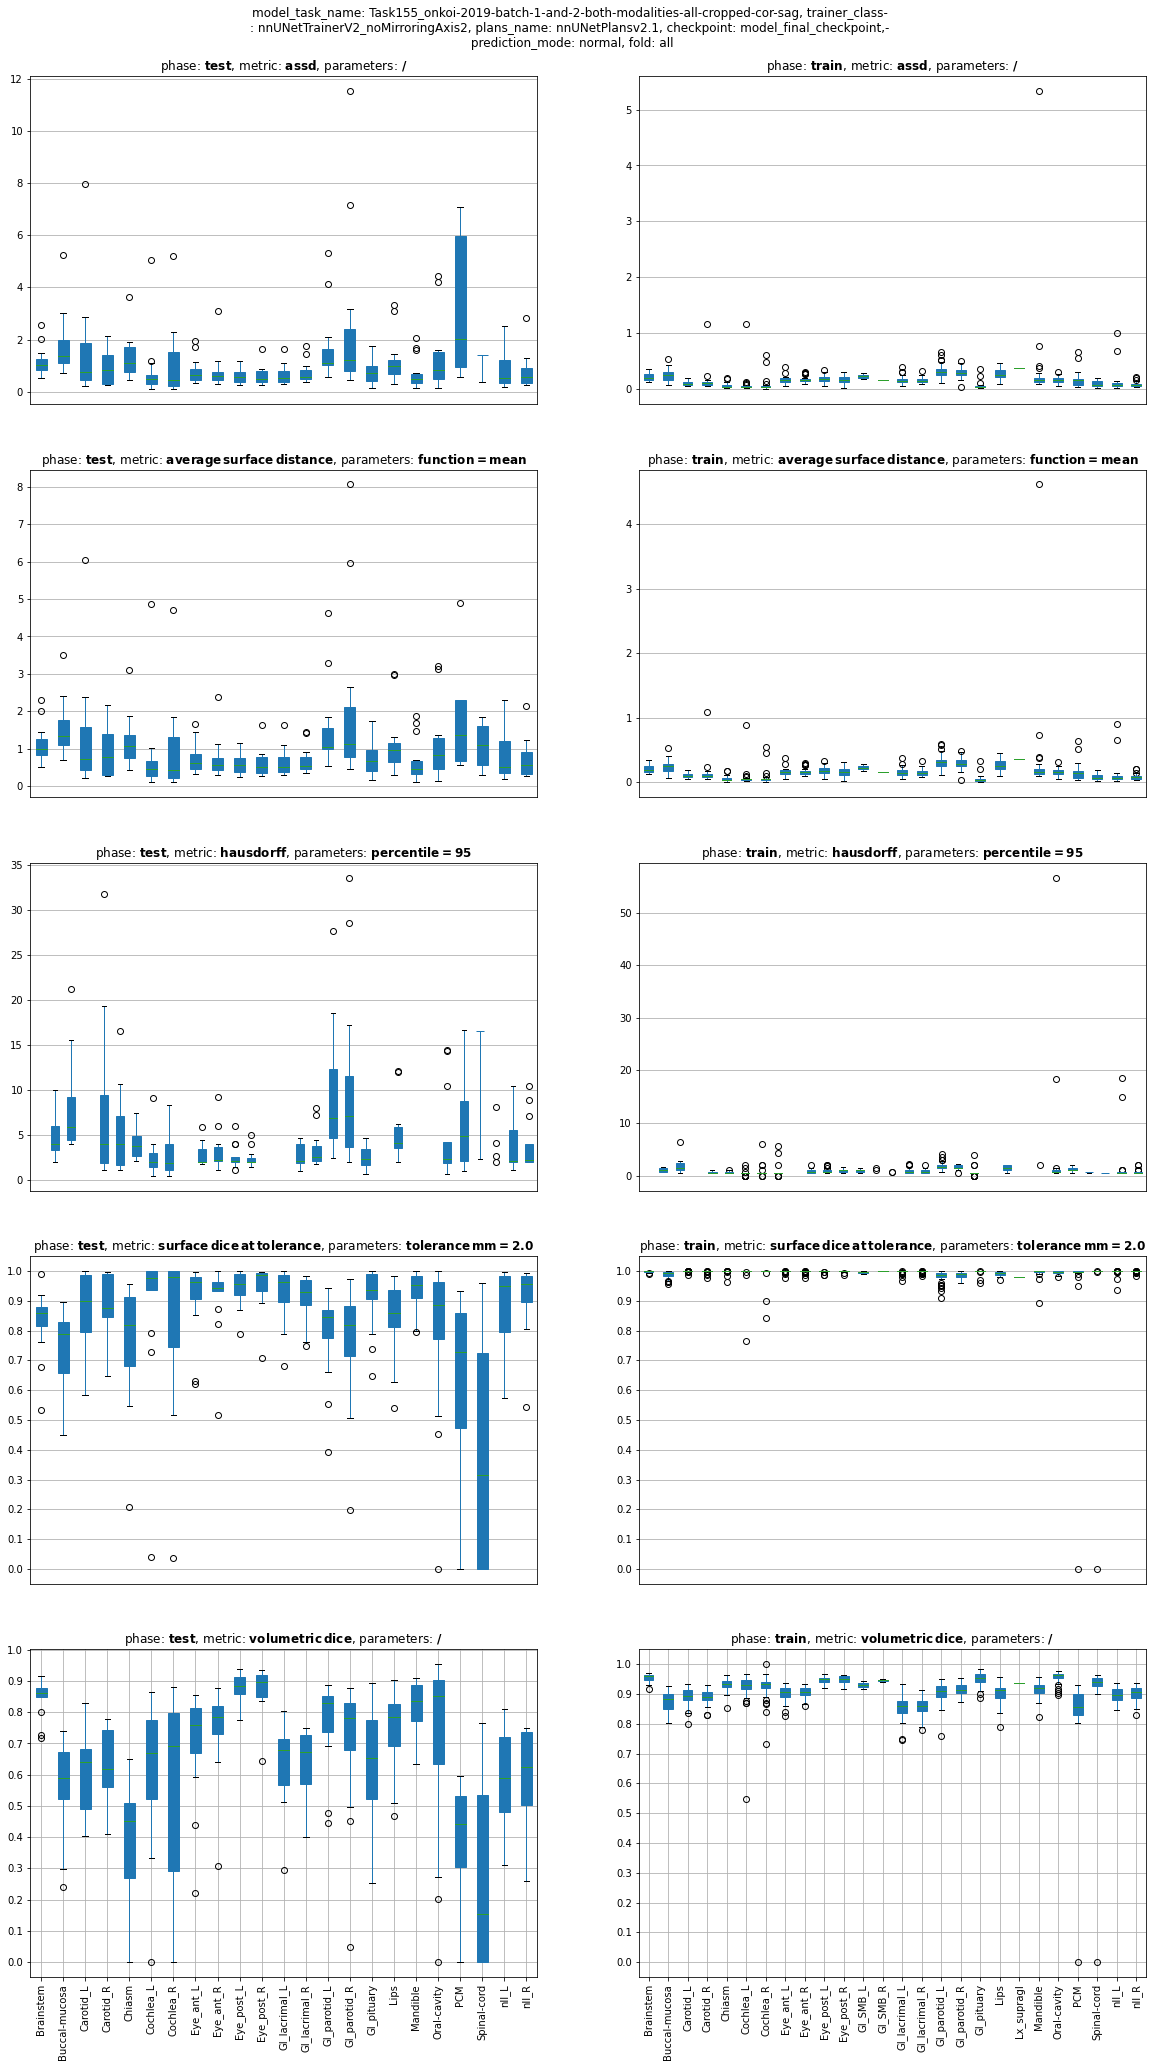

In [110]:
dataset = "Task155_onkoi-2019-batch-1-and-2-both-modalities-all-cropped-cor-sag"
# stat_test = 'Mann-Whitney'
df = read_csv(dataset)
print(df.columns)
# df
df_pivot = pivot_nnunet_results_df(df)
print(df_pivot.shape)
# df_pivot

df_pivot.columns.names
df_pivot_cleaned, dropped_names, names_to_stay = drop_recurring_columns(df_pivot)
print(dropped_names)
print(names_to_stay)

plot_parameters = ('phase', 'metric')
_tmp = {k: vals for k, vals in names_to_stay.items() if k in plot_parameters}
combinations = [dict(zip(list(_tmp.keys()), combination)) for combination in itertools.product(*list(_tmp.values()))]
combinations
print(combinations, len(combinations))
plot_boxplots(df_pivot, combinations)

In [116]:
compute_mean_std_table(df_pivot)

metric,assd,average_surface_distance,hausdorff,surface_dice_at_tolerance,volumetric_dice,assd,average_surface_distance,hausdorff,surface_dice_at_tolerance,volumetric_dice
phase,test,test,test,test,test,train,train,train,train,train
organ_name,,,,,,,,,,
Arytenoids,NaN,NaN,inf +/- nan,NaN,NaN,NaN,NaN,inf +/- nan,NaN,NaN
Brainstem,1.19 +/- 0.54,1.15 +/- 0.49,5.01 +/- 2.39,0.83 +/- 0.11,0.85 +/- 0.06,0.21 +/- 0.07,0.21 +/- 0.06,inf +/- nan,1.0 +/- 0.0,0.95 +/- 0.01
Buccal-mucosa,1.83 +/- 1.22,1.58 +/- 0.77,inf +/- nan,0.73 +/- 0.13,0.57 +/- 0.16,0.25 +/- 0.1,0.24 +/- 0.1,inf +/- nan,0.99 +/- 0.01,0.88 +/- 0.03
CPI,NaN,NaN,inf +/- nan,NaN,NaN,NaN,NaN,inf +/- nan,NaN,NaN
Carotid_L,1.53 +/- 2.02,1.3 +/- 1.52,7.34 +/- 8.76,0.87 +/- 0.14,0.61 +/- 0.14,0.1 +/- 0.03,0.1 +/- 0.03,inf +/- nan,1.0 +/- 0.0,0.89 +/- 0.03
Carotid_R,0.92 +/- 0.66,0.87 +/- 0.63,5.37 +/- 4.58,0.89 +/- 0.11,0.63 +/- 0.12,0.13 +/- 0.17,0.13 +/- 0.16,inf +/- nan,1.0 +/- 0.0,0.89 +/- 0.02
Chiasm,1.29 +/- 0.83,1.18 +/- 0.68,4.09 +/- 1.68,0.77 +/- 0.2,0.39 +/- 0.19,0.05 +/- 0.04,0.05 +/- 0.04,inf +/- nan,1.0 +/- 0.01,0.93 +/- 0.02
Cochlea_L,0.84 +/- 1.25,0.8 +/- 1.2,2.55 +/- 2.12,0.88 +/- 0.26,0.6 +/- 0.24,0.07 +/- 0.18,0.07 +/- 0.13,inf +/- nan,0.99 +/- 0.04,0.92 +/- 0.06


## LOAD 156 
ISBI baseline model, all organs, CT and MRI T1 modalities, coregistered all images to common frame, cropped in cor and sag to eliminate background and in ax to reduce size

Index(['Unnamed: 0', 'organ_name', 'organ_label', 'missing_organ_on_gt',
       'missing_organ_on_pred', 'metric', 'value', 'parameters',
       'model_task_number', 'model_task_name', 'fold', 'trainer_class',
       'plans_name', 'checkpoint', 'prediction_mode', 'phase', 'fname'],
      dtype='object')
(78, 310)
{'model_task_name': 'Task156_onkoi-2019-isbi', 'trainer_class': 'nnUNetTrainerV2_noMirroringAxis2', 'plans_name': 'nnUNetPlansv2.1', 'checkpoint': 'model_final_checkpoint', 'prediction_mode': 'normal', 'fold': 'all'}
{'phase': ['test', 'train'], 'metric': ['assd', 'average_surface_distance', 'hausdorff', 'surface_dice_at_tolerance', 'volumetric_dice'], 'parameters': ['no_parameters', 'function=mean', 'percentile=95', 'tolerance_mm=2.0'], 'organ_name': ['Arytenoids', 'Brainstem', 'Buccal-mucosa', 'CPI', 'Carotid_L', 'Carotid_R', 'Chiasm', 'Cochlea_L', 'Cochlea_R', 'Esophagus_cerv', 'Eye_ant_L', 'Eye_ant_R', 'Eye_post_L', 'Eye_post_R', 'Gl_SMB_L', 'Gl_SMB_R', 'Gl_lacrimal_L', 'G

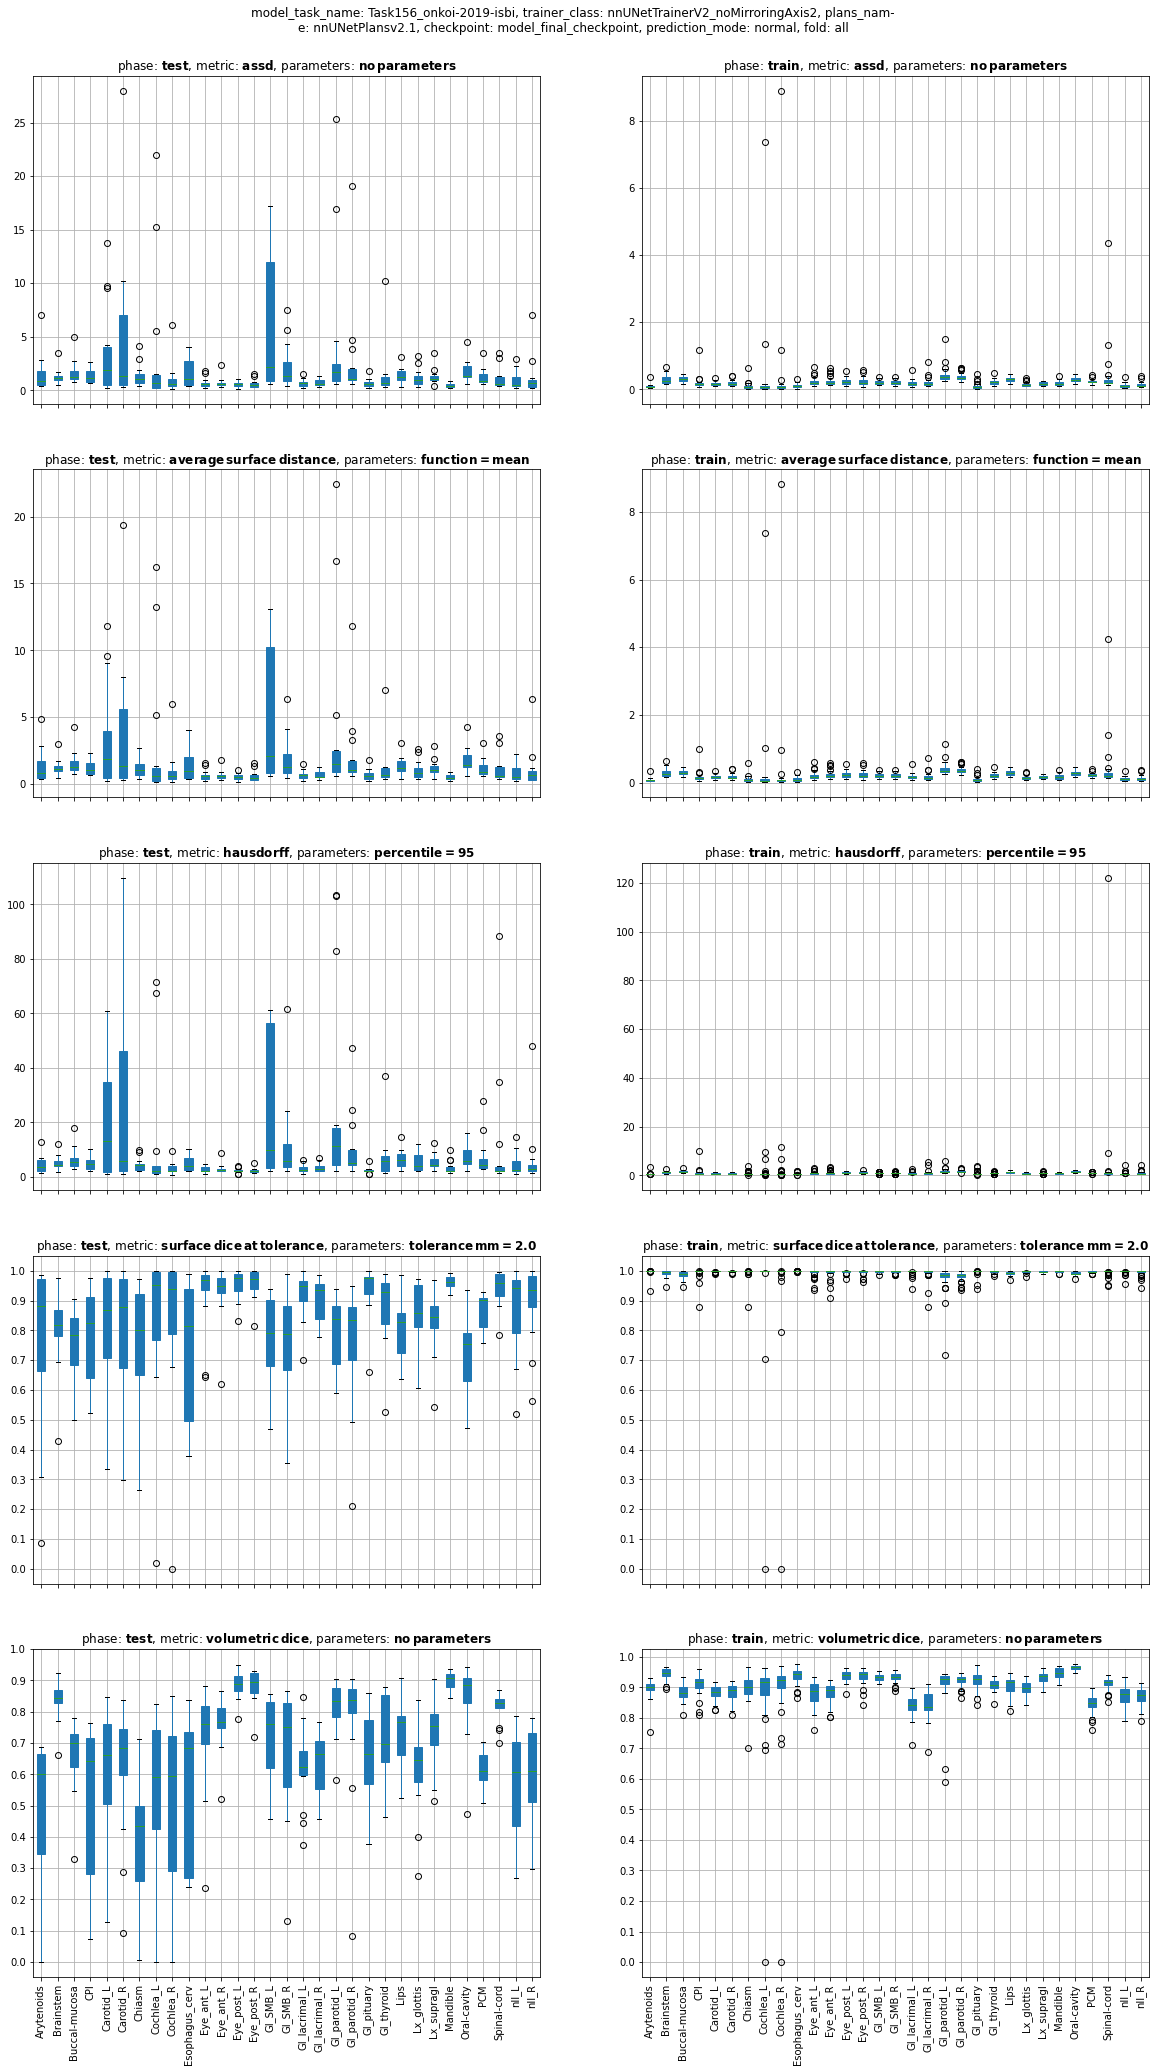

In [45]:
dataset = "Task156_onkoi-2019-isbi"
# stat_test = 'Mann-Whitney'
df = read_csv(dataset)
print(df.columns)
# df


df_pivot = pivot_nnunet_results_df(df)
print(df_pivot.shape)
# df_pivot

df_pivot.columns.names
df_pivot_cleaned, dropped_names, names_to_stay = drop_recurring_columns(df_pivot)
print(dropped_names)
print(names_to_stay)
df_pivot_cleaned.xs('onkoi-2019-isbi_056', level='fname').xs('hausdorff', level='metric', axis=1)

plot_parameters = ('phase', 'metric')
_tmp = {k: vals for k, vals in names_to_stay.items() if k in plot_parameters}
combinations = [dict(zip(list(_tmp.keys()), combination)) for combination in itertools.product(*list(_tmp.values()))]
combinations
# print(combinations, len(combinations))
plot_boxplots(df_pivot, combinations)
plt.savefig('isbi_results.pdf')

In [118]:
df_table = compute_mean_std_table(df_pivot)
df_table.to_excel('isbi_excel.xlsx')
df_table

metric                           assd                         \
phase                            test                  train   
organ_name                                                     
Arytenoids      1.577 +/- 1.884; N=12  0.082 +/- 0.055; N=38   
Brainstem       1.304 +/- 0.694; N=14   0.291 +/- 0.12; N=41   
Buccal-mucosa   1.663 +/- 1.083; N=14  0.306 +/- 0.075; N=42   
CPI             1.346 +/- 0.647; N=12  0.179 +/- 0.176; N=37   
Carotid_L       3.623 +/- 4.293; N=14  0.168 +/- 0.053; N=42   
Carotid_R       5.021 +/- 7.441; N=14   0.175 +/- 0.07; N=42   
Chiasm          1.376 +/- 1.041; N=14    0.097 +/- 0.1; N=40   
Cochlea_L       3.505 +/- 6.677; N=14   0.28 +/- 1.154; N=41   
Cochlea_R        1.097 +/- 1.53; N=14  0.311 +/- 1.385; N=41   
Esophagus_cerv   1.695 +/- 1.479; N=8  0.102 +/- 0.067; N=32   
Eye_ant_L         0.7 +/- 0.473; N=14  0.216 +/- 0.115; N=40   
Eye_ant_R       0.701 +/- 0.501; N=14  0.232 +/- 0.116; N=39   
Eye_post_L      0.547 +/- 0.242; N=14  0.233 +/- 0.093; N=40   
Eye_post_R      0.604 +/- 0.386; N=14  0.228 +/- 0.102; N=41   
Gl_SMB_L        5.695 +/- 6.246; N=14   0.21 +/- 0.061; N=42   
Gl_SMB_R        2.279 +/- 2.131; N=14  0.215 +/- 0.066; N=42   
Gl_lacrimal_L   0.715 +/- 0.358; N=14  0.179 +/- 0.086; N=39   
Gl_lacrimal_R   0.732 +/- 0.334; N=14  0.191 +/- 0.127; N=39   
Gl_parotid_L    4.471 +/- 7.332; N=14  0.415 +/- 0.207; N=42   
Gl_parotid_R    2.861 +/- 4.814; N=14  0.379 +/- 0.098; N=42   
Gl_pituary      0.683 +/- 0.413; N=14  0.094 +/- 0.081; N=40   
Gl_thyroid      1.681 +/- 2.862; N=11  0.219 +/- 0.075; N=37   
Lips            1.389 +/- 0.695; N=14  0.298 +/- 0.072; N=42   
Lx_glottis       1.185 +/- 0.89; N=12   0.15 +/- 0.054; N=38   
Lx_supragl       1.301 +/- 0.78; N=12  0.173 +/- 0.044; N=41   
Mandible        0.508 +/- 0.208; N=14  0.179 +/- 0.074; N=42   
Oral-cavity      1.73 +/- 1.039; N=14    0.29 +/- 0.07; N=42   
PCM             1.237 +/- 0.759; N=14  0.235 +/- 0.052; N=42   
Spinal-cord     1.101 +/- 0.977; N=14  0.359 +/- 0.664; N=42   
nII_L           0.956 +/- 0.837; N=14   0.115 +/- 0.06; N=40   
nII_R            1.207 +/- 1.79; N=14  0.132 +/- 0.072; N=40   

metric         average_surface_distance                         \
phase                              test                  train   
organ_name                                                       
Arytenoids        1.344 +/- 1.326; N=12  0.081 +/- 0.051; N=38   
Brainstem         1.255 +/- 0.585; N=14  0.285 +/- 0.114; N=41   
Buccal-mucosa     1.558 +/- 0.906; N=14  0.297 +/- 0.071; N=42   
CPI               1.214 +/- 0.531; N=12  0.172 +/- 0.149; N=37   
Carotid_L         3.409 +/- 3.885; N=14  0.166 +/- 0.052; N=42   
Carotid_R         3.968 +/- 5.232; N=14  0.173 +/- 0.069; N=42   
Chiasm            1.204 +/- 0.723; N=14   0.094 +/- 0.09; N=40   
Cochlea_L          2.88 +/- 5.205; N=14  0.271 +/- 1.148; N=41   
Cochlea_R         1.024 +/- 1.496; N=14  0.302 +/- 1.371; N=41   
Esophagus_cerv     1.467 +/- 1.301; N=8  0.101 +/- 0.066; N=32   
Eye_ant_L         0.666 +/- 0.409; N=14  0.211 +/- 0.104; N=40   
Eye_ant_R         0.647 +/- 0.369; N=14  0.227 +/- 0.105; N=39   
Eye_post_L         0.543 +/- 0.24; N=14  0.231 +/- 0.093; N=40   
Eye_post_R        0.605 +/- 0.398; N=14  0.226 +/- 0.102; N=41   
Gl_SMB_L          4.966 +/- 5.261; N=14   0.207 +/- 0.06; N=42   
Gl_SMB_R          1.923 +/- 1.648; N=14  0.211 +/- 0.065; N=42   
Gl_lacrimal_L      0.688 +/- 0.34; N=14  0.176 +/- 0.081; N=39   
Gl_lacrimal_R     0.688 +/- 0.301; N=14  0.186 +/- 0.114; N=39   
Gl_parotid_L       4.23 +/- 6.693; N=14  0.397 +/- 0.158; N=42   
Gl_parotid_R      2.212 +/- 2.943; N=14   0.37 +/- 0.092; N=42   
Gl_pituary        0.671 +/- 0.407; N=14  0.091 +/- 0.074; N=40   
Gl_thyroid         1.35 +/- 1.924; N=11  0.215 +/- 0.073; N=37   
Lips              1.362 +/- 0.683; N=14   0.292 +/- 0.07; N=42   
Lx_glottis        1.084 +/- 0.757; N=12  0.147 +/- 0.052; N=38   
Lx_supragl        1.236 +/- 0.621; N=12  

In [125]:
res_df = pd.DataFrame()
res_df['vol_DSC'] = df_table.xs(('volumetric_dice', 'test'), level=('metric', 'phase'), axis=1)[('volumetric_dice', 'test')].str.split("+").str[0].astype(float)*100
res_df['bib_code'] = 'local'
res_df['first_author'] = 'OUR'
res_df['year'] = 2021
res_df['Dataset'] = 'ONKOI'
res_df['Modality'] = 'CT+MR'
res_df['OAR'] = res_df.index
res_df["OAR"].replace({"nII_L": "Optic_nerve_L", "nII_R": "Optic_nerve_R", 'Eye_post_L': 'Eye_L', 'Eye_post_R': 'Eye_R', 'Eye_ant_L': 'Lens_L', 'Eye_ant_R': 'Lens_R'}, inplace=True)

In [126]:
res_df

In [153]:
df_table.xs(('hausdorff', 'test'), level=('metric', 'phase'), axis=1)[('hausdorff', 'test')].str.split("+").str[0].astype(float).mean()

8.186903225806452

In [151]:
res_df['vol_DSC'].mean()

67.83225806451613

## Dice

(99, 516, 390)


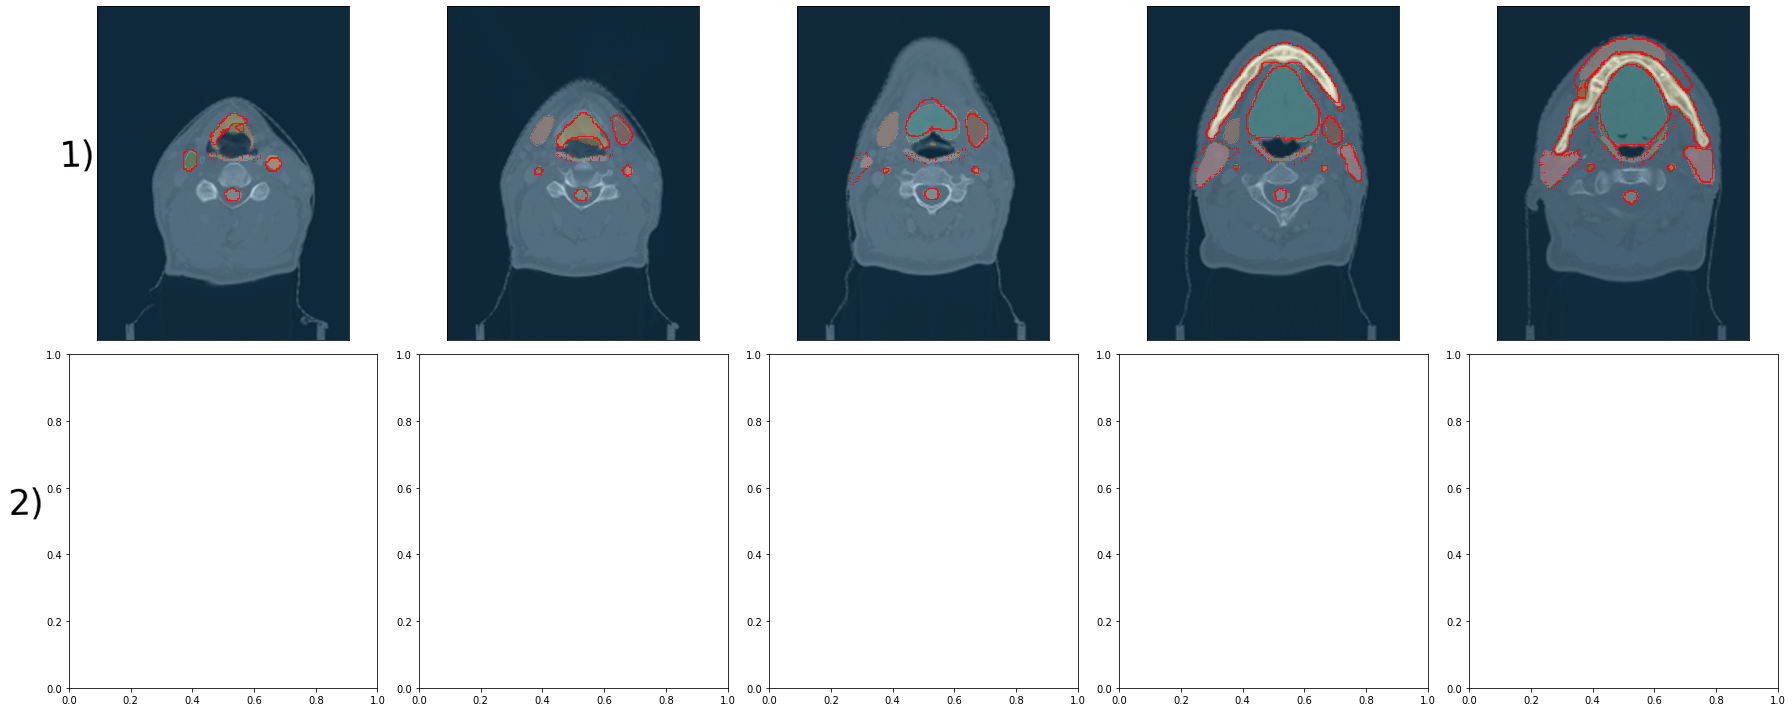

In [160]:
import matplotlib
from matplotlib.colors import ListedColormap
import scipy.ndimage as ndimage
good_case = {'raw': '/media/medical/projects/head_and_neck/PDDCA/0522c0598/original/ct.nii.gz', 
             'name': 'PDDCA-HN1_050', 
             'dataset': 'Task156_onkoi-2019-isbi', 
            'img': '/media/medical/projects/head_and_neck/nnUnet/Task156_onkoi-2019-isbi/imagesTs/onkoi-2019-isbi_050_0000.nii.gz', 
            'gt': '/media/medical/projects/head_and_neck/nnUnet/Task156_onkoi-2019-isbi/labelsTs/onkoi-2019-isbi_050.nii.gz', 
            'pred': '/media/medical/projects/head_and_neck/nnUnet/Task156_onkoi-2019-isbi/results/pred/test/onkoi-2019-isbi_050.nii.gz', }

bad_case = {'raw': '/media/medical/projects/head_and_neck/onkoi_2019/Original-dcm_conv_2/16/preprocessed/elastix_spline23/ct.nii.gz', 
            'name': 'onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed_053',
            'dataset': 'Task113_onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed',
           'img': '/media/medical/projects/head_and_neck/nnUnet/Task113_onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed/imagesTs/onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed_053_0000.nii.gz', 
            'pred': '/media/medical/projects/head_and_neck/nnUnet/Task129_PDDCA-HN1-ONKOI-double-reference-onkoi-10-train-20-test-noBadCasesInTrain/results/foldall/Task113_onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed/test/onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed_053.nii.gz',
            'gt': ['/media/medical/projects/head_and_neck/nnUnet/Task113_onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed/labelsTs/onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed_053.nii.gz', 
                  '/media/medical/projects/head_and_neck/nnUnet/Task113_onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed/labelsTs/onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed_054.nii.gz']
           }

def load_sitk_and_to_np(pth):
    img_sitk = sitk.ReadImage(pth)
    spacing = img_sitk.GetSpacing() # cor, sag ,ax
    img_np = sitk.GetArrayFromImage(img_sitk)
    return img_np
def get_edge(slice_np):
    return ndimage.generic_gradient_magnitude(
        slice_np, ndimage.sobel
        ).astype(bool).astype(np.uint8)
def plot_case(axes, slices, image, gt, pred):
    mask_cmap_yellow = ListedColormap([[0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 0.0, 1.0]])
    mask_cmap_red = ListedColormap([[0.0, 0.0, 0.0, 0.0], [1.0, 0, 0.0, 1.0]])
    mask_cmap_blue = ListedColormap([[0.0, 0.0, 0.0, 0.0], [0, 0, 1.0, 1.0]])
    mask_cmap_green = ListedColormap([[0.0, 0.0, 0.0, 0.0], [0, 1.0, 0, 1.0]])
    gt_cmaps = [mask_cmap_green, mask_cmap_blue]
    
    if not isinstance(gt, (list, tuple)):
        gt = [gt]
        gt_cmaps = [mask_cmap_red]
        
    for enum, slc in enumerate(range(20,50,7)):
        ax = axes[enum]
        ax.imshow(image[slc], cmap='gray')
        ax.imshow(pred[slc], alpha=0.3, cmap=matplotlib.cm.get_cmap('tab20'))
        for enum2, g in enumerate(gt):
            ax.imshow(get_edge(gt[enum2][slc]), alpha=0.8, cmap=gt_cmaps[enum2])
            
    [plt.setp(axi.get_xticklabels(), visible=False) for axi in axes.ravel()]
    [plt.setp(axi.get_yticklabels(), visible=False) for axi in axes.ravel()]
    [axi.tick_params(axis='both', which='both', length=0) for axi in axes.ravel()]
    
    
    
img_good = load_sitk_and_to_np(good_case['img'])
gt_good = load_sitk_and_to_np(good_case['gt'])
pred_good = load_sitk_and_to_np(good_case['pred'])
img_bad = load_sitk_and_to_np(bad_case['img'])
pred_bad = load_sitk_and_to_np(bad_case['pred'])
gt_bad = [load_sitk_and_to_np(i) for i in bad_case['gt']]

print(img_good.shape)
fig, axs = plt.subplots(2, 5, figsize=(25,10))
plot_case(axes=axs[0], slices=list(range(20,50,7)), image=img_good, gt=gt_good, pred=pred_good)
# plot_case(axes=axs[1], slices=list(range(20,50,7)), image=img_bad, gt=gt_bad, pred=pred_bad)
[axs[i, 0].set_ylabel(f'{i+1})', rotation=np.pi/2, fontsize=35, labelpad=20) for i in range(axs.shape[0])]
plt.tight_layout()
# if save_plots: 
#     plt.savefig(f'figures/SPIE_best_worst.png', bbox_inches = 'tight', facecolor='white')

In [16]:
a = np.round(np.random.rand(3, 4)).astype(bool)*False
print(a)
a.astype(int).sum()

[[False False False False]
 [False False False False]
 [False False False False]]


0

# BENCHMARKING

In [133]:
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

In [134]:
save_plots = False
plots_format = "pdf"
oar_abbrev = {
    "Gl": "gland",
    "SMG": "submandibular gland",
    "TMJ": "temporomandibular joint",
    "PCM": "pharyngeal constrictor muscles",
    "Inf": "inferior",
    "Mid": "medial",
    "Sup": "superior",
    "Lx": "larynx",
    "L": "left",
    "R": "right",
}
modalities_abbrev = {
    "sMRI": "synthetic MRI",
    "CBCT": "cone beam CT",
    "LF MRI": "low field MRI",
}


In [135]:
df = pd.read_excel(
    join(
        r"/media/medical/projects/head_and_neck/onkoi_2019", "SOTA_results_stacked.xlsx"
    ),
    engine="openpyxl",
    header=[0],
    index_col=0,
)
df = pd.concat([df, res_df], ignore_index=True)
df["OAR"].replace({"nII_L": "Optic_nerve_L", "nII_R": "Optic_nerve_R"}, inplace=True)
df

,bib_code,first_author,year,Dataset,Modality,OAR,Comments,vol_DSC
0,Ibragimov2017SegmentationNetworks:,Ibragimov,2017,Private,CT,Chiasm,NaN,37.4
1,Ibragimov2017SegmentationNetworks:,Ibragimov,2017,Private,CT,Eye_L,NaN,88.4
2,Ibragimov2017SegmentationNetworks:,Ibragimov,2017,Private,CT,Eye_R,NaN,87.7
3,Ibragimov2017SegmentationNetworks:,Ibragimov,2017,Private,CT,Gl_SMB_L,NaN,69.7
4,Ibragimov2017SegmentationNetworks:,Ibragimov,2017,Private,CT,Gl_SMB_R,NaN,73.0
...,...,...,...,...,...,...,...,...
436,local,OUR,2021,ONKOI,CT+MR,Oral-cavity,NaN,84.5
437,local,OUR,2021,ONKOI,CT+MR,PCM,NaN,61.7
438,local,OUR,2021,ONKOI,CT+MR,Spinal-cord,NaN,81.2
439,local,OUR,2021,ONKOI,CT+MR,Optic_nerve_L,NaN,57.2


## PDDCA

In [136]:
# PDDCA heatmap
df_pddca = df[df["Dataset"].isin(["PDDCA", 'local'])].copy(deep=True)
df_pddca = df_pddca.pivot(
    index=["bib_code", "first_author", "year", "Modality", "Comments"],
    columns="OAR",
    values="vol_DSC",
)
df_pddca.sort_index(level=["year", "first_author"], ascending=True, inplace=True)
df_pddca["name"] = (
    df_pddca.index.get_level_values("first_author").astype(str)
    + " et al., "
    + df_pddca.index.get_level_values("year").astype(str)
)
citations_matching = [
    f"{name}: " + r"\cite{" + bib + "}"
    for name, bib in zip(
        df_pddca["name"].to_list(),
        df_pddca.index.get_level_values("bib_code").to_list(),
    )
]
print(", ".join(list(dict.fromkeys(citations_matching))))
df_pddca.set_index("name", drop=True, inplace=True)
# df_pddca["AVG"] = df_pddca.mean(axis=1)
# df_pddca.loc["AVG", :] = df_pddca.mean(axis=0)
print(df_pddca.columns)
# df_pddca = df_pddca[['Gl_parotid_L', 'Gl_parotid_R']]
df_pddca = df_pddca.loc[df_pddca.notna().any(axis=1)]
# df_pddca.loc["OUR model 1)", :] = [89.2, 89.5]
# df_pddca.loc["OUR model 2)", :] = [88.9, 89.6]
df_pddca

Fritscher et al., 2016: \cite{Fritscher2016DeepImages}, Hansch et al., 2018: \cite{Hansch2018EvaluationImages}, Nikolov et al., 2018: \cite{Nikolov2018DeepRadiotherapy}, Ren et al., 2018: \cite{Ren2018InterleavedImages}, Tong et al., 2018: \cite{Tong2018FullyNetworks}, Zhu et al., 2018: \cite{Zhu2018AnatomyNet:Anatomy}, Tang et al., 2019: \cite{Tang2019ClinicallyImages}, Tappeiner et al., 2019: \cite{Tappeiner2019Multi-organApproach}, Tong et al., 2019: \cite{Tong2019ShapeImages}, Gou et al., 2020: \cite{Gou2020Self-channel-and-spatial-attentionImages}, Yang et al., 2020: \cite{Yang2020SyntheticPlanning}, Gao et al., 2021: \cite{Gao2021FocusNetv2:Images}, Veeraraghavan et al., 2021: \cite{Veeraraghavan2021Nested-blockSegmentation}
Index(['Brainstem', 'Chiasm', 'Gl_SMB_L', 'Gl_SMB_R', 'Gl_parotid_L',
       'Gl_parotid_R', 'Mandible', 'Optic_nerve_L', 'Optic_nerve_R'],
      dtype='object', name='OAR')


OAR,Brainstem,Chiasm,Gl_SMB_L,Gl_SMB_R,Gl_parotid_L,Gl_parotid_R,Mandible,Optic_nerve_L,Optic_nerve_R
name,,,,,,,,,
"Fritscher et al., 2016",NaN,49.00,65.00,65.00,81.00,81.00,NaN,NaN,NaN
"Hansch et al., 2018",NaN,NaN,NaN,NaN,88.00,NaN,NaN,NaN,NaN
"Nikolov et al., 2018",84.20,NaN,76.50,79.20,88.10,86.60,93.80,71.60,69.10
"Ren et al., 2018",NaN,58.00,NaN,NaN,NaN,NaN,NaN,72.00,70.00
"Tong et al., 2018",86.97,58.35,75.48,81.31,83.49,83.18,93.67,65.31,68.89
"Zhu et al., 2018",86.65,53.22,81.37,81.30,88.07,87.35,92.51,72.10,70.64
"Tang et al., 2019",87.50,61.50,82.30,81.50,88.70,87.50,95.00,74.80,72.30
"Tappeiner et al., 2019",82.00,42.00,NaN,NaN,80.00,81.00,91.00,64.00,63.00
"Tong et al., 2019",86.72,59.16,80.65,81.86,85.49,85.77,93.91,66.38,69.91


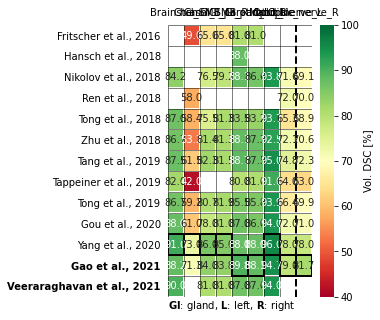

In [137]:
plt.close("all")
plt.figure(figsize=(3, 5))
ax = sns.heatmap(
    df_pddca,
    square=False,
    cmap="RdYlGn",
    annot=True, 
    annot_kws={"ha": 'center',"va": 'center'},
    fmt=".1f",
    linewidths=0.5,
    vmin=df_pddca.min().min() if df_pddca.min().min() < 40 else 40,
    vmax=100,
    cbar_kws={"fraction": 0.09},
)
plt.tick_params(
    axis="both",
    which="major",
    labelsize=10,
    labelbottom=False,
    bottom=False,
    top=False,
    labeltop=True,
    left=False,
)
ax.collections[0].colorbar.set_label("Vol. DSC [%]")
ax.hlines(
    list(range(df_pddca.shape[0])),
    *ax.get_xlim(),
    colors="k",
    linewidth=0.5,
    linestyles="solid",
)
ax.vlines(
    list(range(df_pddca.shape[1] - 1)),
    *ax.get_ylim(),
    colors="k",
    linewidth=0.5,
    linestyles="solid",
)
# ax.hlines(
#     [df_pddca.shape[0] - 2],
#     *ax.get_xlim(),
#     colors="k",
#     linewidth=2,
#     linestyles="dashed",
# )
ax.vlines(
    [df_pddca.shape[1] - 1],
    *ax.get_ylim(),
    colors="k",
    linewidth=2,
    linestyles="dashed",
)
ax.set_xlabel("")
ax.set_ylabel("")

# bold cells that include best result for organ
tmp = df_pddca.copy(deep=True).reset_index(drop=True)
for e, i in enumerate(tmp.idxmax(axis=0)):
    ax.add_patch(Rectangle((e, i), 1, 1, fill=False, edgecolor="k", lw=2))

oar_abbrev = {
    "Gl": "gland",
    "SMG": "submandibular gland",
    "TMJ": "temporomandibular joint",
    "PCM": "pharyngeal constrictor muscles",
    "Inf": "inferior",
    "Mid": "medial",
    "Sup": "superior",
    "Lx": "larynx",
    "L": "left",
    "R": "right",
}

# print abbreviations description at the bottom of the figure
abbrevs_used = [
    i for i in list(oar_abbrev.keys()) for n in df_pddca.columns.to_list() if i in n
]
sorting_dict = dict(zip(oar_abbrev.keys(), list(range(len(oar_abbrev.keys())))))
abbrevs_used = list(set(abbrevs_used))
abbrevs_num = [sorting_dict[i] for i in abbrevs_used]
abbrevs_used = [x for _, x in sorted(zip(abbrevs_num, abbrevs_used))]
s = [
    r"$\bf{{{key}}}$: {value}".format(key=i, value=oar_abbrev[i]) for i in abbrevs_used
]
plt.text(0, df_pddca.shape[0] + 0.1, ", ".join(s), fontsize=10, ha="left", va="top")

[label.set_fontweight('bold') for label in ax.get_yticklabels()[-2:]]

# plt.show()
# plt.savefig(
#     join(remote_config.project_reports_dir_path, f"{figure_name}.{plot_format}"),
#     bbox_inches="tight",
# )
if save_plots: plt.savefig(f'figures/SPIE_PDDCA_benchmarking.{plots_format}', bbox_inches = 'tight', facecolor='white')


## PRIVATE

Ibragimov et al., 2017: \cite{Ibragimov2017SegmentationNetworks:}, Hansch et al., 2018: \cite{Hansch2018EvaluationImages}, Mocnik et al., 2018: \cite{Mocnik2018SegmentationImages}, Nikolov et al., 2018: \cite{Nikolov2018DeepRadiotherapy}, Willems et al., 2018: \cite{Willems2018ClinicalRadiotherapy}, Zhu et al., 2018: \cite{Zhu2018AnatomyNet:Anatomy}, Chan et al., 2019: \cite{Chan2019ALearning}, Chen et al., 2019: \cite{Chen2019ARadiotherapy}, Heyden et al., 2019: \cite{vanderHeyden2019Dual-energyApproach}, Rhee et al., 2019: \cite{Rhee2019AutomaticNetworks}, Rooij et al., 2019: \cite{vanRooij2019DeepEvaluation}, Sun et al., 2019: \cite{Sun2019AccurateRadiotherapy}, Tang et al., 2019: \cite{Tang2019ClinicallyImages}, Tong et al., 2019: \cite{Tong2019ShapeImages}, Veen et al., 2019: \cite{vanderVeen2019BenefitsCancer}, Dai et al., 2020: \cite{Dai2020SyntheticRadiotherapy}, Kieselmann et al., 2020: \cite{Kieselmann2020CrossmodalityOnly}, Wandewinckle et al., 2020: \cite{Vandewinckele2020S

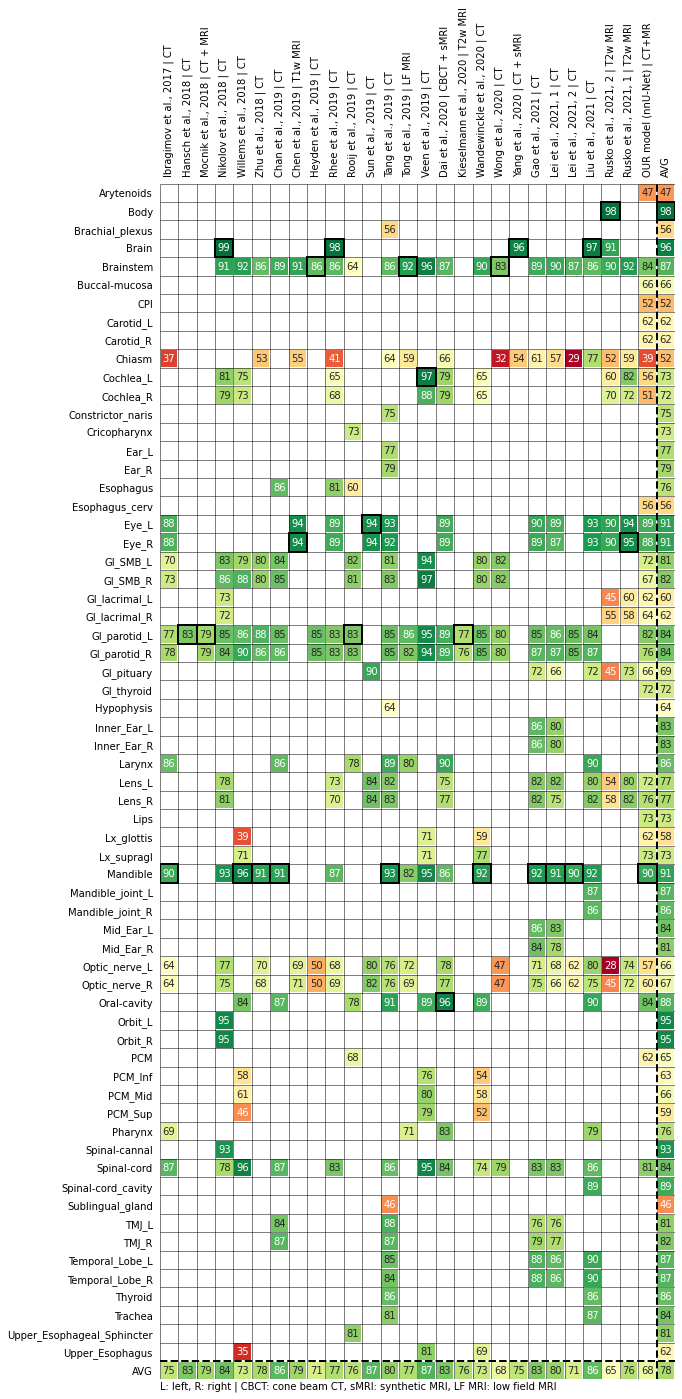

In [186]:
# PRIVATE datasets heatmap
figure_name = "private_dataset_results"

df_private = df[df["Dataset"] != "PDDCA"].copy(deep=True)
df_private["dataset_id"] = ""
for unique_bib_code in df_private["bib_code"].unique():
    unique_datasets = df_private.loc[df_private["bib_code"] == unique_bib_code][
        "Dataset"
    ].unique()
    if unique_datasets.shape[0] > 1:
        dataset_list = df_private.loc[df_private["bib_code"] == unique_bib_code][
            "Dataset"
        ].tolist()
        for enum, dataset in enumerate(unique_datasets):
            dataset_list = [
                ", " + str(enum + 1) if i == dataset else i for i in dataset_list
            ]
        df_private.loc[
            df_private["bib_code"] == unique_bib_code, "dataset_id"
        ] = dataset_list
df_private = df_private.pivot(
    index=["bib_code", "first_author", "year", "dataset_id", "Modality"],
    columns="OAR",
    values="vol_DSC",
)
df_private.sort_index(level=["year", "first_author"], ascending=True, inplace=True)
df_private["name"] = (
    df_private.index.get_level_values("first_author").astype(str)
    + " et al., "
    + df_private.index.get_level_values("year").astype(str)
)
modalities = df_private.index.get_level_values("Modality").tolist()
citations_matching = [
    f"{name}: " + r"\cite{" + bib + "}"
    for name, bib in zip(
        df_private["name"].to_list(),
        df_private.index.get_level_values("bib_code").to_list(),
    )
]
print(", ".join(list(dict.fromkeys(citations_matching))))
df_private["name"] = (
    df_private["name"]
    + df_private.index.get_level_values("dataset_id").astype(str)
    + " | "
    + df_private.index.get_level_values("Modality").astype(str)
)
df_private.set_index("name", drop=True, inplace=True)
df_private["AVG"] = df_private.mean(axis=1)
df_private.loc["AVG", :] = df_private.mean(axis=0)

reidx = list(range(df_private.shape[0]))
reidx[24] = 26
reidx[26] = 24
df_private = df_private.iloc[reidx]
idxs = list(df_private.index)
idxs[-2] = 'OUR model (nnU-Net) | CT+MR'
df_private.index = idxs
df_private =df_private.transpose()

plt.close("all")
plt.figure(figsize=(10, 22))
ax = sns.heatmap(
    df_private,
    square=True,
    cbar=False,
    cmap="RdYlGn",
    annot=True,
    linewidths=0.5,
    vmin=df_private.min().min() if df_private.min().min() < 40 else 40,
    vmax=100,
    cbar_kws={"fraction": 0.05},
)
plt.tick_params(
    axis="both",
    which="major",
    labelsize=10,
    labelbottom=False,
    bottom=False,
    top=False,
    labeltop=True,
    left=False,
)
ax.tick_params(axis="x", rotation=90)
# ax.collections[0].colorbar.set_label("Vol. DSC [%]")
ax.set_xlabel("")
ax.set_ylabel("")
ax.hlines(
    list(range(df_private.shape[0] - 1)),
    *ax.get_xlim(),
    colors="k",
    linewidth=0.5,
    linestyles="solid",
)
ax.vlines(
    list(range(df_private.shape[1] - 1)),
    *ax.get_ylim(),
    colors="k",
    linewidth=0.5,
    linestyles="solid",
)
ax.hlines(
    [df_private.shape[0] - 1],
    *ax.get_xlim(),
    colors="k",
    linewidth=2,
    linestyles="dashed",
)
ax.vlines(
    [df_private.shape[1] - 1],
    *ax.get_ylim(),
    colors="k",
    linewidth=2,
    linestyles="dashed",
)

# bold cells that include best result for organ
tmp = df_private.copy(deep=True).reset_index(drop=True)
for e, i in enumerate(tmp.idxmax(axis=0)):
    ax.add_patch(Rectangle((e, i), 1, 1, fill=False, edgecolor="k", lw=2))

# add background effects to empty cells in rows that include results on MRI images
isMRI = np.array(["MRI" in i for i in df_private.index.tolist()]).reshape(-1, 1)
to_draw = np.repeat(isMRI, df_private.shape[1], axis=1) & df_private.isna().values
# for e, (i, j) in enumerate(zip(*np.where(to_draw))):
#     ax.add_patch(Rectangle((j, i), 1, 1, fill=False, hatch="..", alpha=0.75))

# print abbreviations description at the bottom of the figure
abbrevs_used = [
    i
    for i in list(oar_abbrev.keys())
    for n in df_private.columns.to_list()
    if i in n
]  # check which abbrevs are used in heatmap
sorting_dict = dict(
    zip(
        oar_abbrev.keys(),
        list(range(len(oar_abbrev.keys()))),
    )
)  # prepare for sorting abbrevs to match the order as defined in dataset_config
abbrevs_used = list(set(abbrevs_used))  # get unique
abbrevs_num = [sorting_dict[i] for i in abbrevs_used]
abbrevs_used = [x for _, x in sorted(zip(abbrevs_num, abbrevs_used))]
# s = [
#     r"$\bf{{{key}}}$: {value}".format(key=i, value=oar_abbrev[i])
#     for i in abbrevs_used
# ]
s = [
    r"{key}: {value}".format(key=i, value=oar_abbrev[i])
    for i in abbrevs_used
]

modals_used = [
    i
    for i in list(modalities_abbrev.keys())
    for n in df_private.columns.to_list()
    if i in n
]
modals_used = list(set(modals_used))
# s2 = [
#     r"$\bf{{{key}}}$: {value}".format(
#         key=i.replace(" ", r"\;"), value=modalities_abbrev[i]
#     )
#     for i in modals_used
# ]
s2 = [
    r"{key}: {value}".format(
        key=i.replace(" ", r" "), value=modalities_abbrev[i]
    )
    for i in modals_used
]

plt.text(
    0,
    df_private.shape[0] + 0.1,
    split_text(", ".join(s) + " | " + ", ".join(s2), 90),
    fontsize=10,
    wrap=False,
    ha="left",
    va="top",
)
# plt.title('Rezultati na podatkovni bazi PDDCA')
# plt.show()
# plt.savefig(
#     join(remote_config.project_reports_dir_path, f"{figure_name}.{plot_format}"),
#     bbox_inches="tight",
# )
plt.savefig('benchmarking.png', facecolor='white', bbox_inches='tight')

In [184]:
s2

[]

In [185]:
modals_used

[]